# TP2: First Machine Learning Models
Now that we have visualised the data using Time-frequency and time-series format and understood the dynamic of sleep a bit more in details, we will try to train and interpret the output of some machine learning models to predict sleep stages.

At the end of this tutorial you will be able to make your first submission to the contest.


In [2]:
pip install dtreeviz==1.4.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
cd "C:\Users\Piquant Mark\Desktop\CENTRALE\3A\MMF\SD9\Machine_Learning\Kaagle\input\automated-sleep-staging-beacon-biosignals-2023-2024"

C:\Users\Piquant Mark\Desktop\CENTRALE\3A\MMF\SD9\Machine_Learning\Kaagle\input\automated-sleep-staging-beacon-biosignals-2023-2024


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import spectrogram
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import os
import random as rd
import json
import pandas as pd

## Building spectral and statistical features from EEG data
In this simple example, we will use features based on the power located in each frequency band, the relative power in the delta, theta, alpha, sigma and beta range.
We also provide examples on how to compute several statistic of the EEG signals (stdev, min, max, ...)

We will then feed each of these feature to several classifier to assess the performances of a simple model.


In [5]:
frequency_bands = {
        "delta": [0.5, 4],
        "theta": [4, 8],
        "alpha": [8, 12],
       "sigma": [12, 16],
       "beta": [16, 30]
    }

statistics = {
    "stdev":lambda x:np.std(x,1),
    "mean":lambda x:np.mean(np.abs(x),1)
}
variable_lists = list(frequency_bands) + list(statistics)

def get_relative_spectral_power_for_epoch(data):
    """
    Compute the relative spectral power for each of the frequency bands defined above
    """
    EEG_FS = 250
    psds = []
    sfreqs,t,psd = spectrogram(data,250,nperseg = 1000,noverlap = 750)
    psd = np.mean(np.abs(psd),-1)
    spectral_power_band = {}
    for name, freqband in frequency_bands.items():
        spec_power = psd[:,(sfreqs >= freqband[0]) & (sfreqs < freqband[1])]
        spec_power = np.sum(spec_power, 1)
        spectral_power_band[name] = spec_power / np.sum(psd,1)
    return spectral_power_band

def compute_stats(data):
    """
    Compute the statistics of a signal
    """
    EEG_FS = 250
    result = {k:f(data) for k,f in statistics.items()}
    return result

def ndarray_to_list(data):
    for key, value in data.items():
        if isinstance(value, dict):
            ndarray_to_list(value)
        elif isinstance(value, np.ndarray):
            data[key] = value.tolist()
    return data

In this example, we only use the data from the first EEG channel (Frontal-occipital). You can modify the script to add more EEG channels or take into account accelerometer data.

In [6]:
data_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')

for record in os.listdir("training_records"):
    record_number = int(record[-5])
    x = np.load(f'training_records/{record}')
    data_for_record = x[:,1:250 * 30 + 1] # 30 seconds of data at 250Hz  (nombre de données par seconde * nombre de secondes)
    data_for_records[record] = get_relative_spectral_power_for_epoch(data_for_record)
    data_for_records[record].update(compute_stats(data_for_record))
    hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])

variable_list = list(data_for_records[record].keys())

In [7]:
x.shape

(913, 42001)

We split the data between training and test records. 

In [8]:
rd.seed(1234)
records_list = list(data_for_records)
rd.shuffle(records_list)
training_record,test_records = records_list[:4],records_list[4:]

print('Training records: ',training_record)
print('Test records: ', test_records)

Training records:  ['dreem_1.npy', 'dreem_2.npy', 'dreem_5.npy', 'dreem_4.npy']
Test records:  ['dreem_0.npy', 'dreem_3.npy', 'dreem_6.npy']


And build the data under tabular format, each epoch has seven features (one for each frequency band).

In [9]:
def build_dataset(records, data_for_records,hypnogram_for_records):
    X,y = [],[]
    for record in records:
        X_for_record = np.expand_dims(np.array([value for value in data_for_records[record].values()]).T,0)
        y.extend(hypnogram_for_records[record])
        X.extend(X_for_record)
    return np.concatenate(X),y


X_train,y_train = build_dataset(training_record,data_for_records,hypnogram_for_records)
X_test,y_test = build_dataset(test_records,data_for_records,hypnogram_for_records)

In [10]:
print(variable_lists)
print(X_train[0])
print(y_train[0])

['delta', 'theta', 'alpha', 'sigma', 'beta', 'stdev', 'mean']
[8.19154870e-01 4.91601141e-02 1.76703787e-02 8.36290110e-03
 5.43941887e-03 4.60383970e+05 1.64648868e+05]
0


## First model, Logistic regression
First, we try to build a Linear classifier to classify the data using the spectral bands.

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

{'balanced_accuracy': 0.4516066509911415, 'cohen_kappa': 0.45545669760046525, 'macro_f1': 0.43169611023723087}


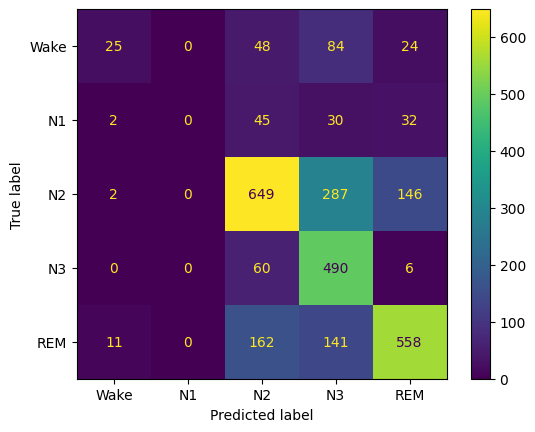

In [11]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
# scale input data and reduce dimension
pipeline = make_pipeline(StandardScaler(),LogisticRegression(max_iter = 200))
pipeline.fit(X_train, y_train)
# linear classifier
# training: fit the model to the data

# test it
predictions = pipeline.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(pipeline, X_test,y_test,display_labels = ['Wake','N1','N2','N3','REM'])

 **Question: What do you think of the performances ? How can you explain the confusion between the sleep stages ?**


Let's have a look at the LR weights to see how the variable are used to perform prediction for each of the sleep stages.
- Delta has a positive weight for N3 prediction and negative for N1, REM and WAKE
- Alpha is correlated with WAKE as well as large stdev
- Sigma range is correlated with N2 sleep and spindles.

In [12]:
df = pd.DataFrame(pipeline[1].coef_)
df.index = ['Wake','N1',"N2","N3","REM"]
df.columns = variable_list
df

,delta,theta,alpha,sigma,beta,stdev,mean
Wake,-0.109878,-0.446099,0.946276,-0.025694,-0.343392,1.730918,0.030418
N1,-0.537338,-0.273558,0.120785,0.143097,0.755545,0.344368,0.407332
N2,-0.233037,-0.125922,-0.723905,1.412796,-0.615289,-0.016849,1.637907
N3,1.203279,0.384369,-0.275398,-0.619188,-1.603740,-3.346647,-2.414665
REM,-0.323026,0.461210,-0.067758,-0.911012,1.806875,1.288209,0.339008


**Question: Plot some sleep epochs where the model confused some sleep stages, why did these confusions happen ?**

In [50]:
# Get the indices of the misclassified epochs
misclassified_indices = np.where(predictions != y_test)[0]
print(len(misclassified_indices))
print(len(y_test))
print((len(predictions)-len(misclassified_indices))/len(predictions))
# Select a few of these indices to plot
# Here we select the first 5 misclassified epochs, you can change this as needed
selected_indices = misclassified_indices[200:205]
print(selected_indices)

899
2802
0.679157744468237
[1030 1031 1032 1033 1035]


In [14]:
from lspopt import spectrogram_lspopt
def get_average_spectrum_for_epochs(eeg,epochs):
    """
    Return the average power in each of the fourier bin for several epochs.
    """
    EEG_FS = 250
    psds = []
    for epoch in epochs:
        idx_start,idx_end = 250 * 30 * epoch,250 * 30 * (epoch + 1)
        freqs,t,psd = spectrogram_lspopt(np.clip(eeg[idx_start:idx_end],-150,150),250,nperseg = 1000)
        psds += [np.mean(np.abs(psd),1)]
    return freqs,np.array(psds).mean(0)


def plot_average_spectrum_for_epochs(eeg,epochs):
    """
    Compute and plot the power spectrum of a list of epochs
    """
    freqs,psd = get_average_spectrum_for_epochs(eeg,epochs)
    psd = psd/np.sum(psd)
    plt.plot(freqs, psd)
    plt.xlim(0, 18)
    plt.yscale('log')
    plt.ylim(1e-6,1)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Relative power')

In [ ]:
eeg=np.load('training_records/dreem_0.npy')

In [56]:
plot_average_spectrum_for_epochs(eeg, [3])
# plot_average_spectrum_for_epochs(eeg, [7])
# plot_average_spectrum_for_epochs(eeg, [8])
# plot_average_spectrum_for_epochs(eeg, [688])

plt.show()

ValueError: window is longer than input signal

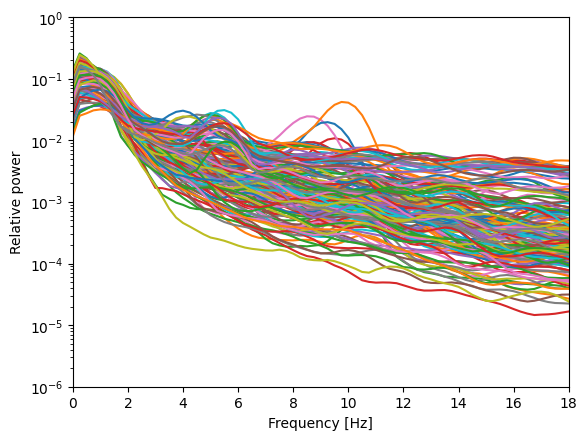

In [51]:
# Plot the average spectrum for all misclassified epochs
for idx in misclassified_indices:
    plot_average_spectrum_for_epochs(eeg, [idx])
plt.show()

## Submitting to the contest


In [15]:
predictions = []
for record in os.listdir("test_records"):
    record_number = int(record[-5])
    x = np.load(f'test_records/{record}')
    raw_data_for_record = x[:,1:250 * 30 + 1]
    data_for_record = get_relative_spectral_power_for_epoch(raw_data_for_record)
    data_for_record.update(compute_stats(raw_data_for_record))
    data_for_record = np.array([value for value in data_for_record.values()]).T
    preds = pipeline.predict(data_for_record)
    for i, pred in enumerate(preds):
        predictions.append({"identifier":record_number * 10000 + i,'target':pred})

predictions = pd.DataFrame(predictions)
print(predictions)

      identifier  target
0          70000       2
1          70001       2
2          70002       2
3          70003       2
4          70004       3
...          ...     ...
2641       90842       0
2642       90843       0
2643       90844       0
2644       90845       4
2645       90846       2

[2646 rows x 2 columns]


In [16]:
# predictions.to_csv('C:\\Users\\Piquant Mark\\Desktop\\CENTRALE\\3A\\MMF\\SD9\\Machine_Learning\\Kaagle\\Working\\submission.csv',index = None)

## Decision Tree



Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

https://scikit-learn.org/stable/modules/tree.html#tree

In [17]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=1234,max_depth = 4, class_weight = 'balanced')
clf.fit(X_train[:,:len(frequency_bands)],y_train)


from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(clf, X_test[:,:len(frequency_bands)], np.array(y_test),
                target_name="target",feature_names = list(frequency_bands), 
           class_names=['Wake','N1','N2','N3','REM'],orientation = 'TD')
viz


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

{'balanced_accuracy': 0.47554733717585407, 'cohen_kappa': 0.3579935270725374, 'macro_f1': 0.4290912514619379}


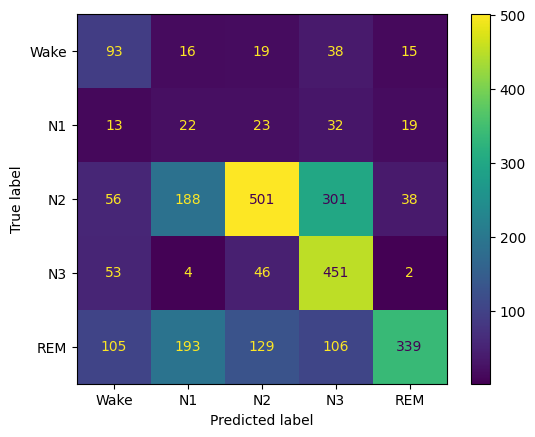

In [18]:
# test it
predictions = clf.predict(X_test[:,:len(frequency_bands)])
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(clf, X_test[:,:len(frequency_bands)],y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

**Question: How do you interpret the split made by the Decision Tree ? Which additional features could improve the performance ?**

## Random forest and ensembling

https://scikit-learn.org/stable/modules/ensemble.html

Here we are going to use the Random Forest method, try to use other ensemble learning functions of the scikit-learn library.
Go to the online documentation of these functions to set the parameters


training...
{'balanced_accuracy': 0.5170554809984618, 'cohen_kappa': 0.5439723102808347, 'macro_f1': 0.4999413036440208}


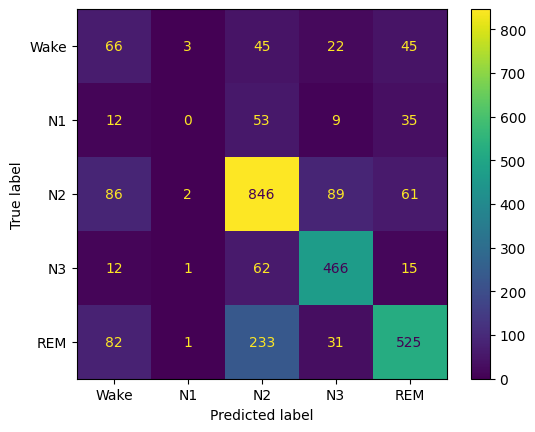

In [19]:

# select a classifier and train it
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=42)
print('training...')
clf_rf.fit(X_train, y_train)

# test it
predictions = clf_rf.predict(X_test)
scores = {'balanced_accuracy': balanced_accuracy_score(y_test, predictions),
            'cohen_kappa': cohen_kappa_score(y_test, predictions),
            'macro_f1': f1_score(y_test, predictions,average ='macro')}

print(scores)
ConfusionMatrixDisplay.from_estimator(clf_rf, X_test,y_test,display_labels = ['Wake','N1','N2','N3','REM'])
plt.show()

Random forests provides several ways to assess the feature importance.
- The first one (Mean Decrease impurity) is based on how much a variable can decrease the impurity in the tree.
- The second one (Permutation importance) is based on how much the permutation between two features decreases the performance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

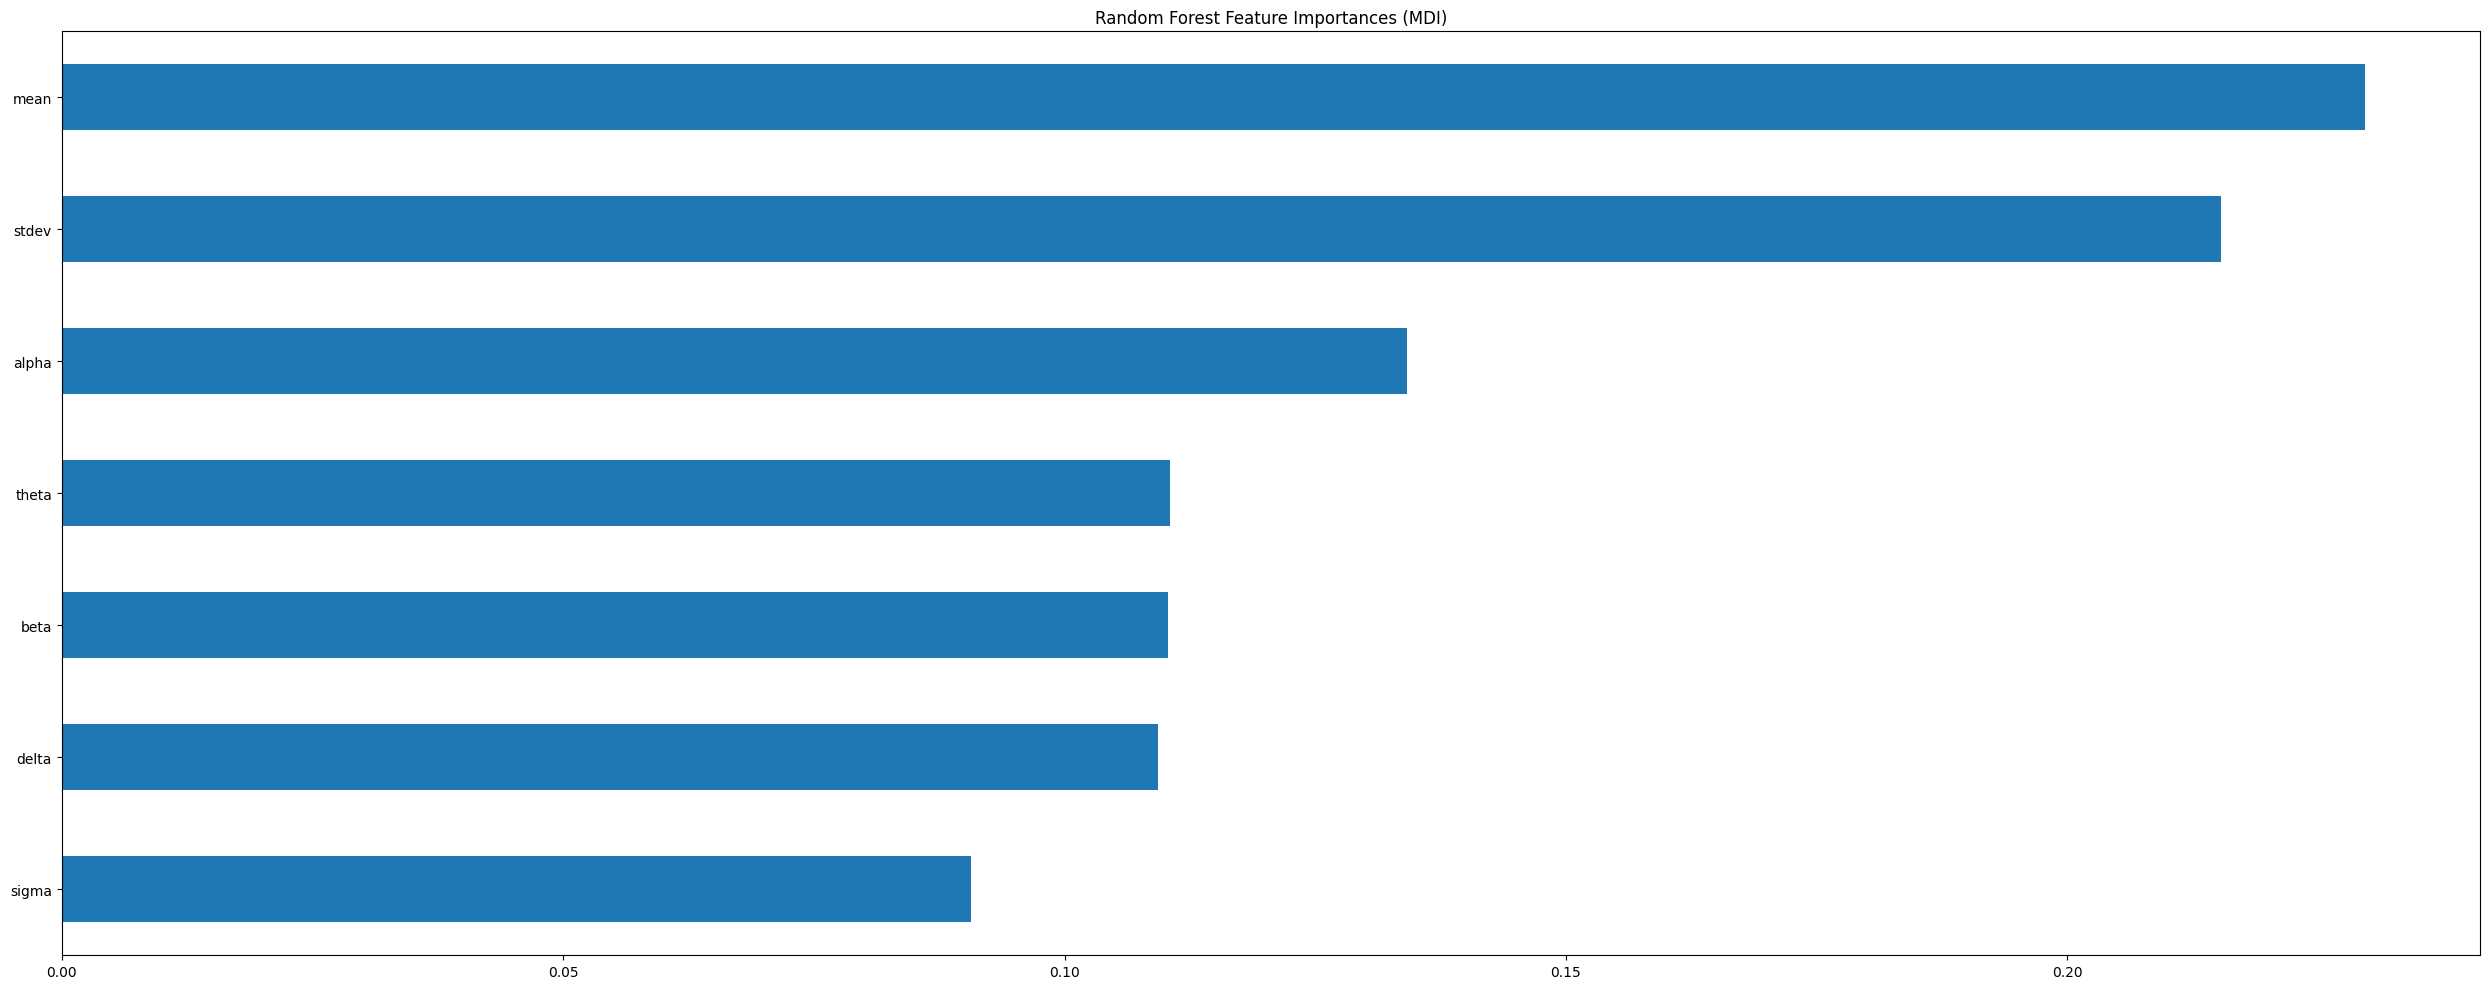

In [20]:
mdi_importances = pd.Series(
    clf_rf[-1].feature_importances_, index=variable_lists
).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(25, 10))
mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

permutations...


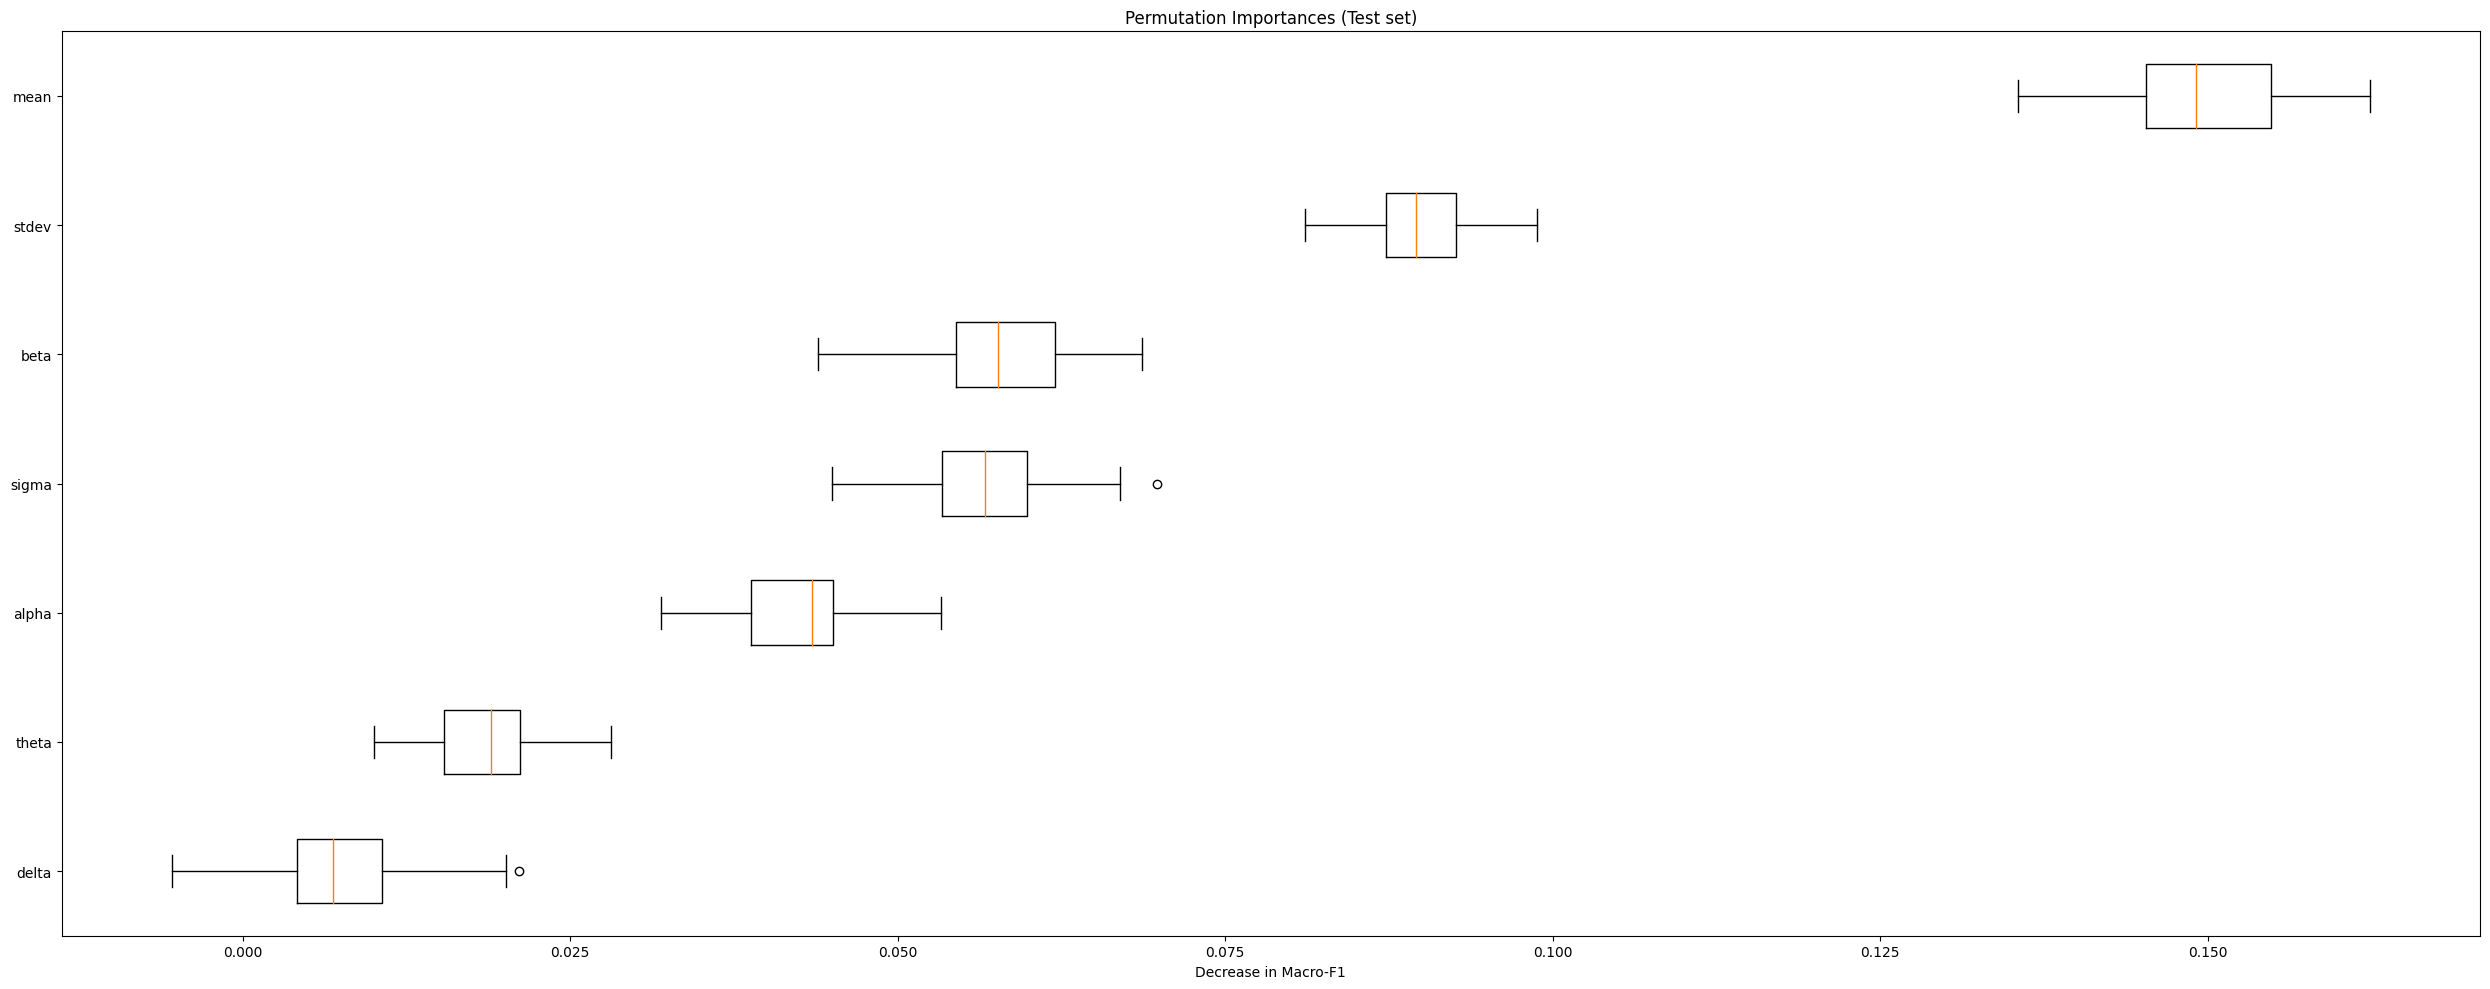

In [21]:
print('permutations...')
from sklearn.inspection import permutation_importance
# We use the build-in sklearn fontion to compute the permutation importance
result = permutation_importance(clf_rf, X_test, y_test, n_repeats=50, random_state=0,scoring = 'f1_macro')
sorted_idx = result.importances_mean.argsort()

# And plot the importance of each variable
fig, ax = plt.subplots(figsize=(25, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=variable_list)
ax.set_title("Permutation Importances (Test set)")
plt.xlabel('Decrease in Macro-F1')
fig.tight_layout()
plt.show()

**Question: What do you think of the importance of each feature ?**

## To begin

### 1. Loading and plotting the data from a record
We seek to plot EEG from the i-ith channel for a specific sleep epoch and the corresponding sleep stage stage

In [22]:
def plot_epoch_from_record(record_name,epoch_index,channel):
    pass

### 2. Computing the Fourier transform of an epoch

Using the previous function, you can now extract the data of a specific sleep epoch and compute the STFT using scipy.

In [23]:
def compute_stft_from_record(record_name,epoch_index,channel):
    pass

## Additional exercises

**Exercise 1:** 

a) By having a look at the litterature, what are the features used the most frequently for EEG classification ? Implement these features to see if you manage to improve performances of the model.

b) We only use the data from a single channel of EEG. Can you use the data from the other EEG channels and acceleromter channels to improve the performances ?

**Exercise 2:** We only used a training and a validation dataset and did not optimize for the model hyperparameters. Which method can be used to select the best model hyperparameters ? Implement it for a Random Forest classifier.

**Excercise 3:** A single type of model was used for each of the model above, ensembling, bagging and boosting often improves the performances of the classifier. Implement an ensemble of different types of model to see if performances improves.

### Appendix 1: Plotting the model mistakes
The previous model does mistakes on some sleep epoch. We seek to plot these specific epochs to understand these errors.

We install yasa in order to be able to plot the spectrogram for the epoch.

In [24]:
pip install yasa

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In order to be able to plot the raw data on the test set, we iterate over the test records, compute the hypnogram and store the raw data. This way we can match the epoch in the raw data with the one in the predicted and ground truth hypnogram.

In [25]:
raw_data_for_records = {}
features_for_records = {}
hypnogram_for_records = {}
hypnograms = pd.read_csv('targets_train.csv')
predicted_hypnograms_for_record = {}
for record in os.listdir("training_records"):
    if record in test_records:
        record_number = int(record[-5])
        x = np.load(f'training_records/{record}')
        raw_data_for_records[record] = x[:,1 + 250 *30:250 * 30 + 1 + 250 *30]
        features_for_record = get_relative_spectral_power_for_epoch(raw_data_for_records[record])
        features_for_record.update(compute_stats(raw_data_for_records[record]))
        features_for_record = np.array([value for value in features_for_record.values()]).T
        hypnogram_for_records[record] = list(hypnograms[hypnograms['record'] == record_number]['target'])
        predicted_hypnograms_for_record[record] = clf_rf.predict(features_for_record)


variable_list = list(data_for_records[record].keys())

First let's just plot the predicted and true hypnograms for all the records.
The model seems to be struggling on record_0.

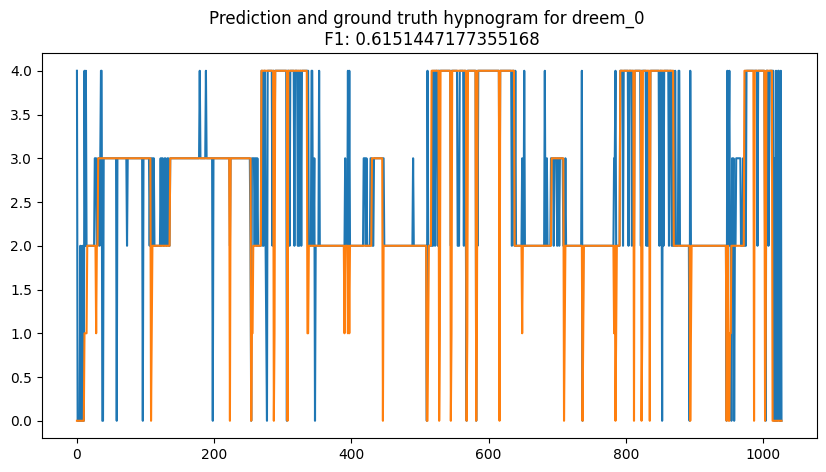

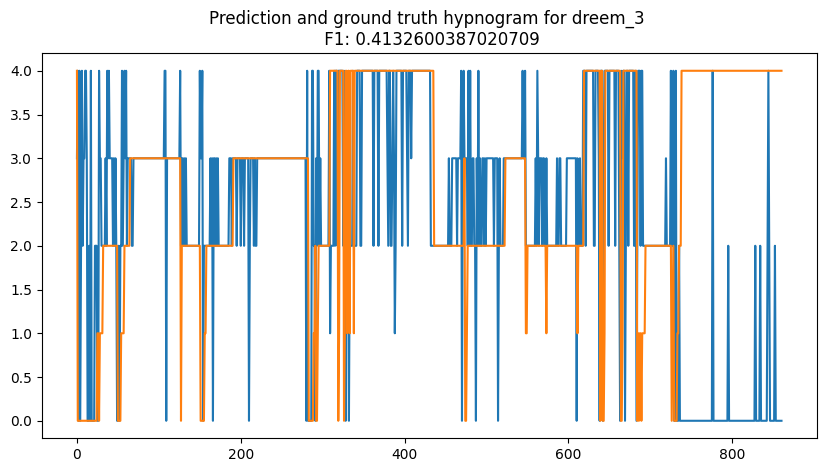

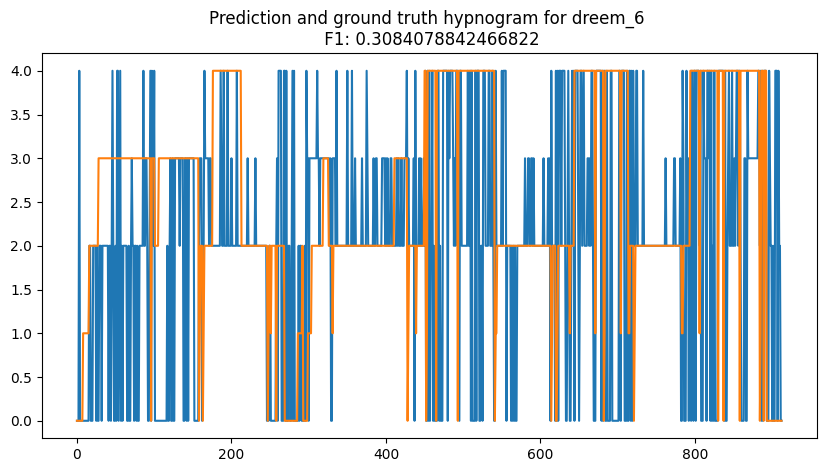

In [26]:
from sklearn.metrics import f1_score
for record in predicted_hypnograms_for_record:
    ground_truth = hypnogram_for_records[record]
    prediction = predicted_hypnograms_for_record[record]
    f1 = f1_score(ground_truth,prediction,average = 'macro')
    plt.figure(figsize = (10,5))
    plt.title(f"Prediction and ground truth hypnogram for {record.replace('.npy','')} \n F1: {f1}")
    plt.plot(predicted_hypnograms_for_record[record])
    plt.plot(hypnogram_for_records[record])
    plt.show()

These functions are used to plot a specific epoch of data under various format:
- Raw EEG signals
- Spectrogram
- Power frequency plot

We also display the predicted and ground truth sleep stage.

In [27]:
import matplotlib.pyplot as plt
import yasa
from lspopt import spectrogram_lspopt

def plot_epoch(epoch_index,raw_data_for_record,ground_truth_hypnogram,predicted_hypnogram):
    """
    Plot the raw signal for a given epoch
    """
    plt.figure(figsize = (20,10))
    plt.title(f'EEG signal for record \n Predicted Sleep Stage {predicted_hypnogram[epoch_index]} \n True Stage: {ground_truth_hypnogram[epoch_index]}')
    plt.plot(np.arange(0,250 * 30) / 250,raw_data_for_record[epoch_index])
    plt.xlim(0,30)
    plt.ylim(-250,250)
    plt.show()
    

def plot_spectrogram(epoch_index,raw_data_for_record,ground_truth_hypnogram,predicted_hypnogram):
    """
    Plot the spectrogram for a given sleep epoch
    """
    start = epoch_index
    end = epoch_index + 1
    title = f'Spectrogram for record \n Predicted Sleep Stage {predicted_hypnogram[epoch_index]} | True Stage: {ground_truth_hypnogram[epoch_index]}'
    f = yasa.plot_spectrogram(np.clip(raw_data_for_record[epoch_index],-200,200), 
                          250,
                          cmap='Spectral_r', win_sec = 0.5,trimperc = 2)
    f.set_figheight(7)
    f.set_figwidth(14)
    f.suptitle(title)
    plt.show()

    

def get_average_spectrum(eeg):
    """
    Return the average power in each of the fourier bin for several epochs.
    """
    EEG_FS = 250
    psds = []
    freqs,t,psd = spectrogram_lspopt(np.clip(eeg,-200,200),250,nperseg = 1000)
    return freqs,psd.mean(1)

def plot_average_spectrum_for_epoch(epoch_index,raw_data_for_record,ground_truth_hypnogram,predicted_hypnogram):
    """
    Compute and plot the power spectrum of a list of epochs
    """
    plt.figure(figsize = (12,5))
    plt.title(f'Spectral power for record \n Predicted Sleep Stage {predicted_hypnogram[epoch_index]} \n True Stage: {ground_truth_hypnogram[epoch_index]}')
    freqs,psd = get_average_spectrum(raw_data_for_record[epoch_index])
    psd = psd/np.sum(psd)
    plt.plot(freqs, psd)
    plt.xlim(0, 18)
    plt.yscale('log')
    plt.ylim(1e-6,1)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Relative power')
    plt.show()
    


With this function, we can plot a few epochs for which the model was right and some other epoch for which the model is wrong.

First, we select the data from record 5 - arbitrary decision - and the list of epoch for which the model is right and wrong.

In [28]:
record = 'dreem_3.npy'
hypnogram = hypnogram_for_records[record]
predicted_hypnogram = predicted_hypnograms_for_record[record]
raw_data = raw_data_for_records[record]
correct_indexes = np.where(hypnogram == predicted_hypnogram)[0]
wrong_indexes = np.where(hypnogram != predicted_hypnogram)[0]

We randomly select three epochs for which the model is wright and three epoch for which the model is right.

In [29]:
correct_indexes_to_plot = np.random.choice(correct_indexes, 3,replace = False)
wrong_indexes_to_plot = np.random.choice(wrong_indexes, 3,replace = False)

For all the true and wrong epochs we will now plot the data.

########
235


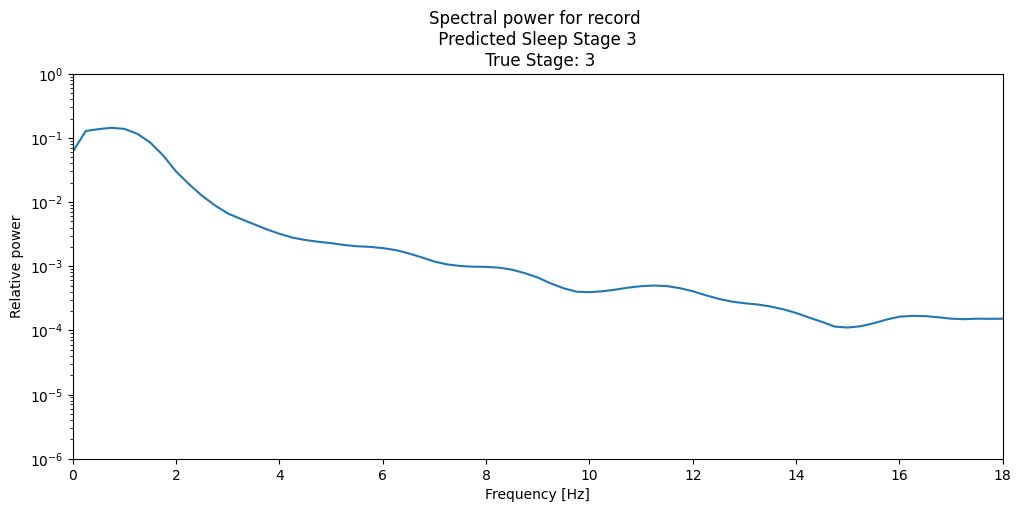

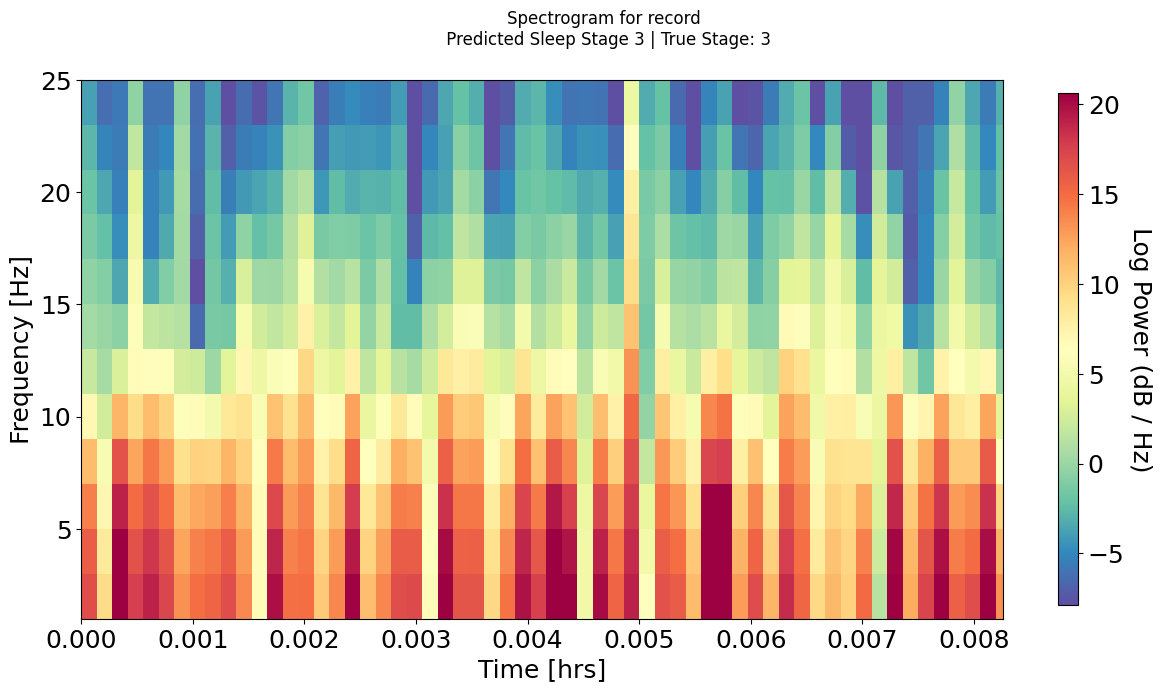

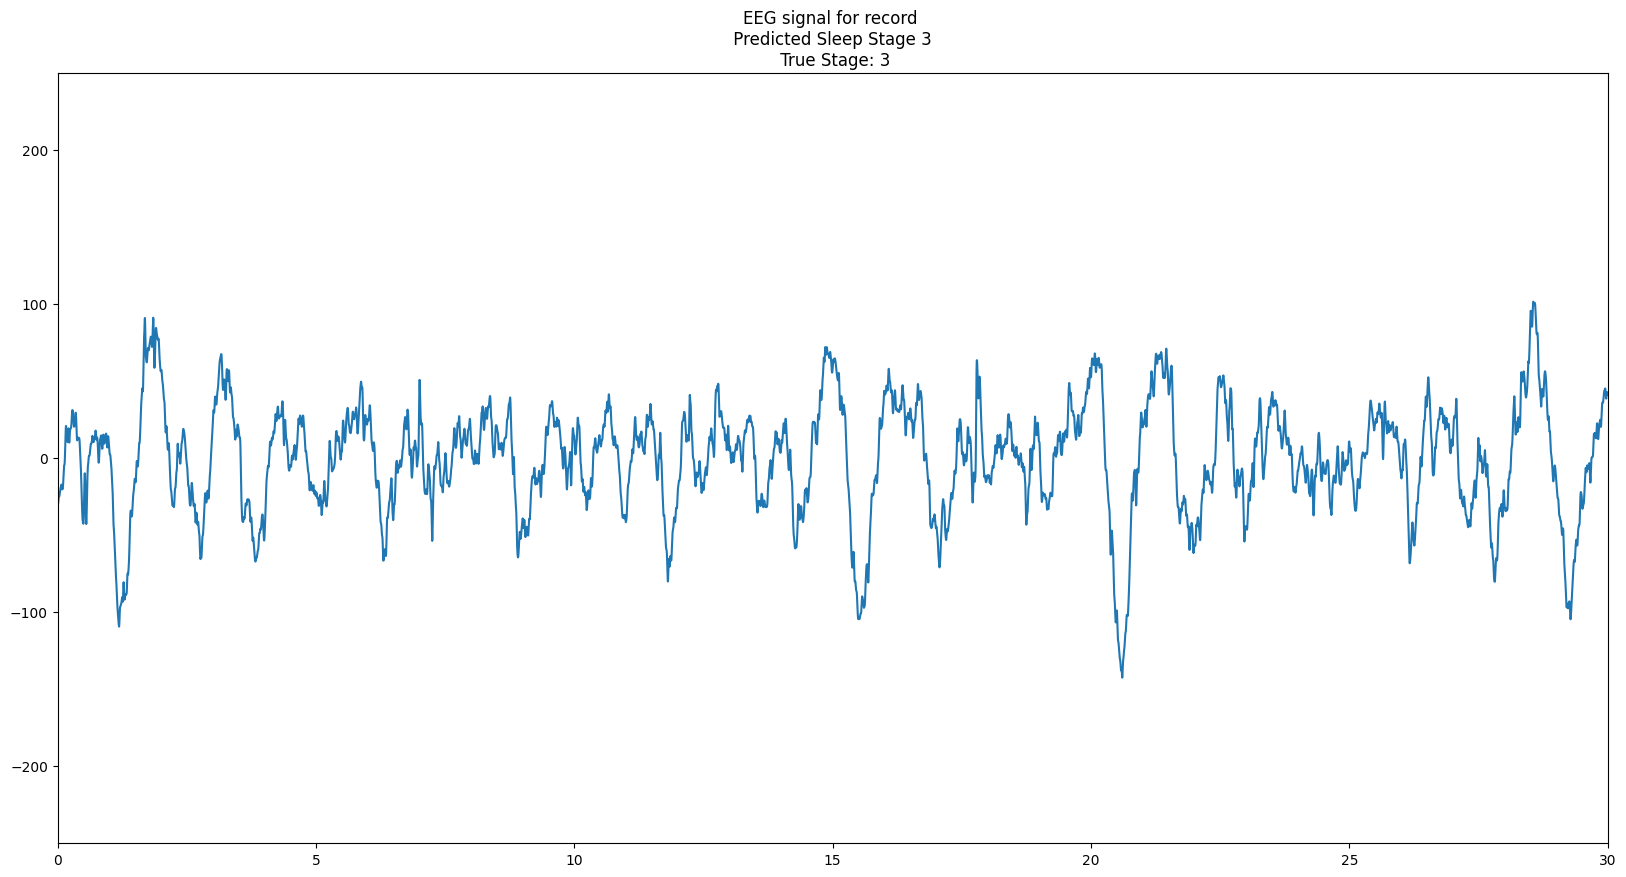

########
457


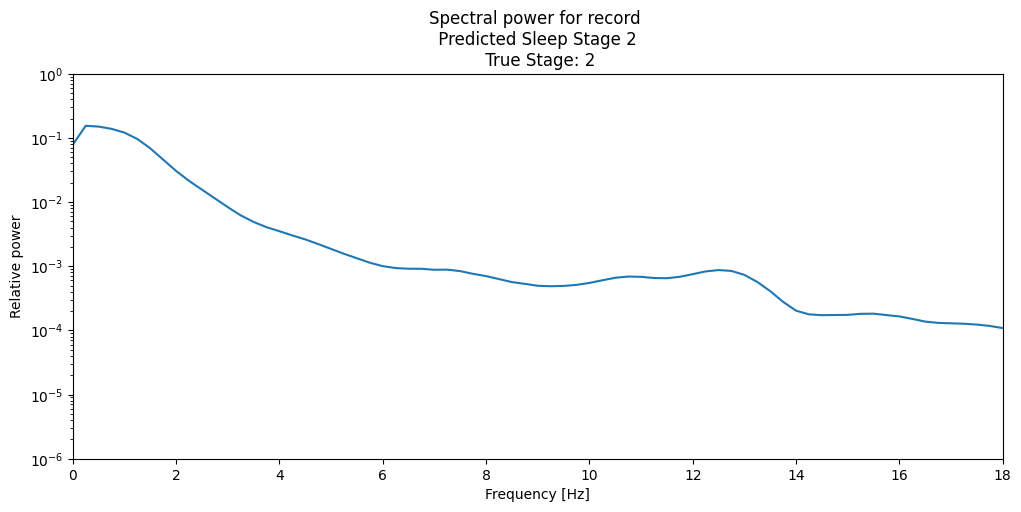

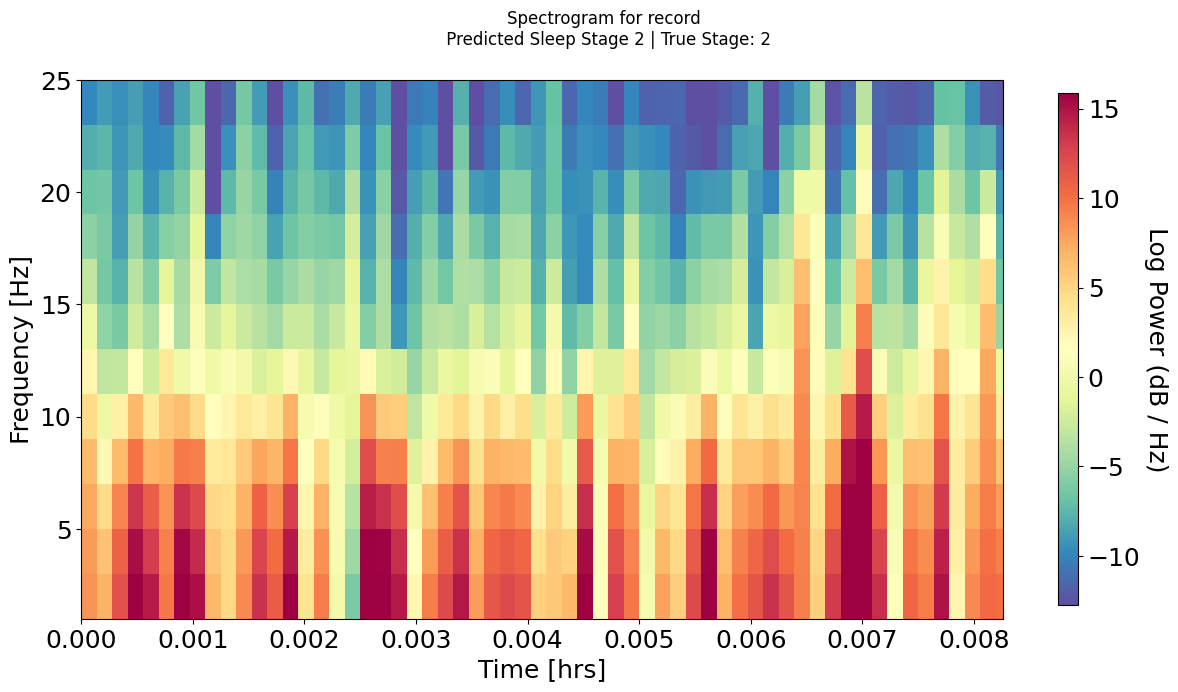

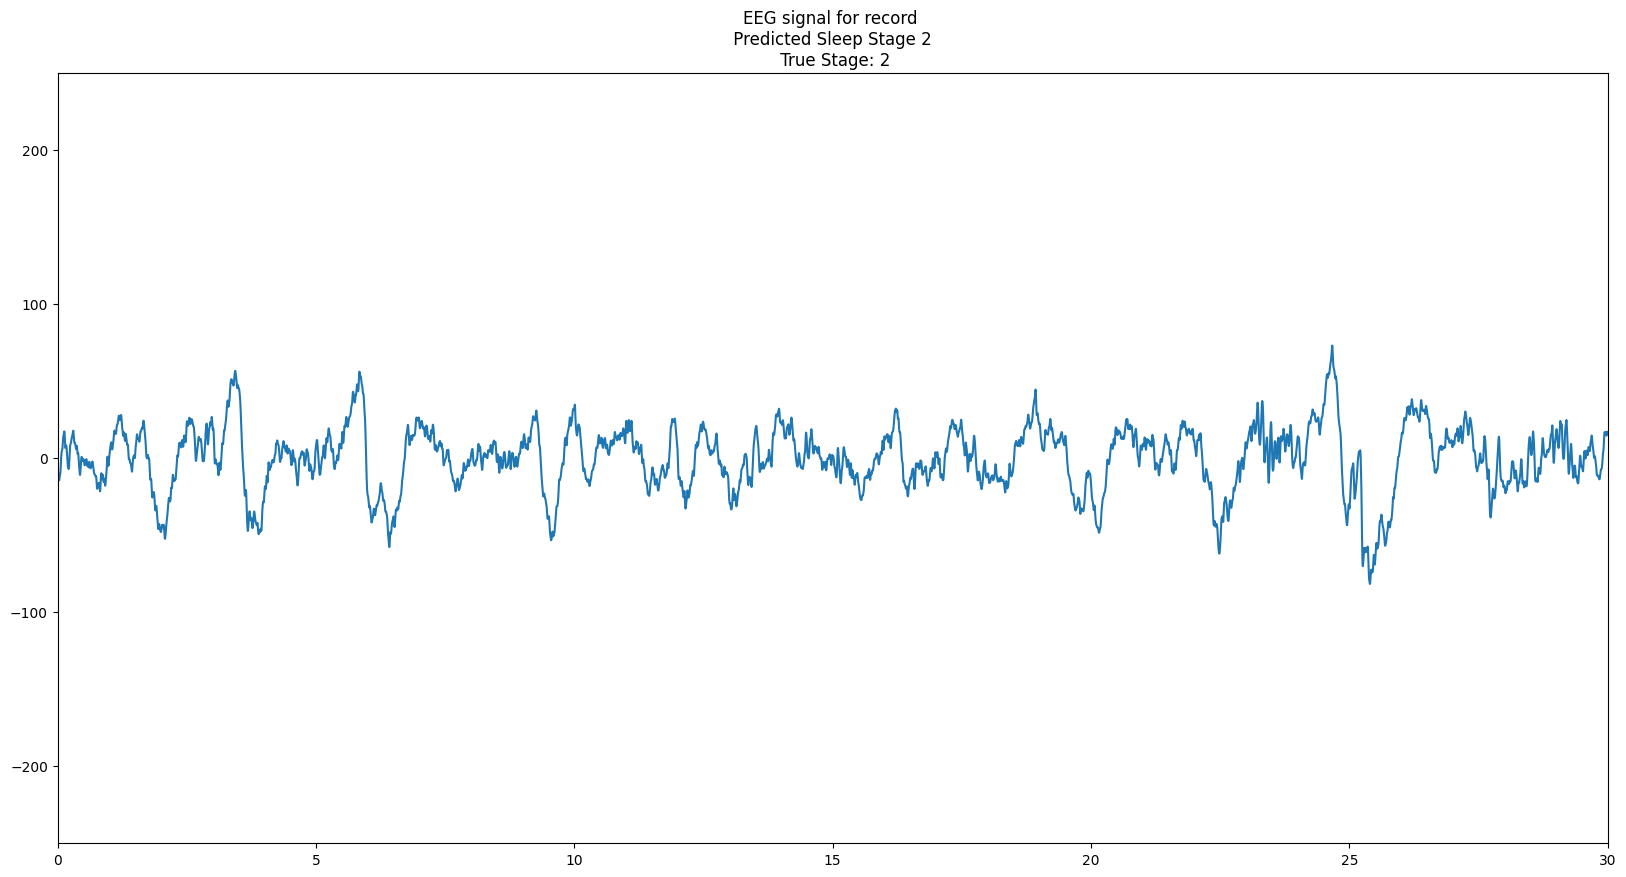

########
542


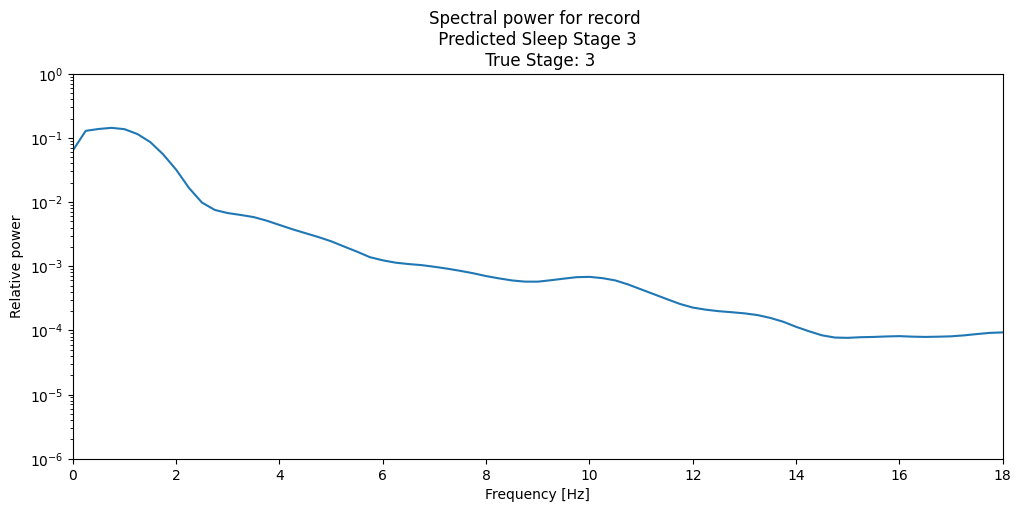

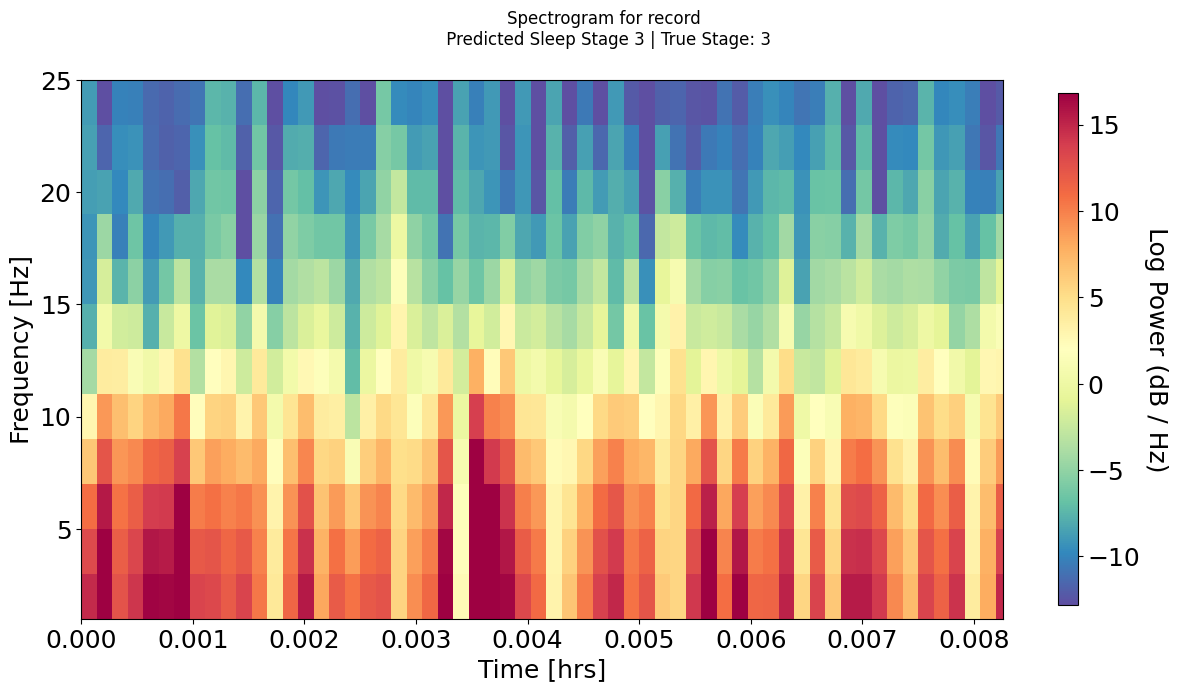

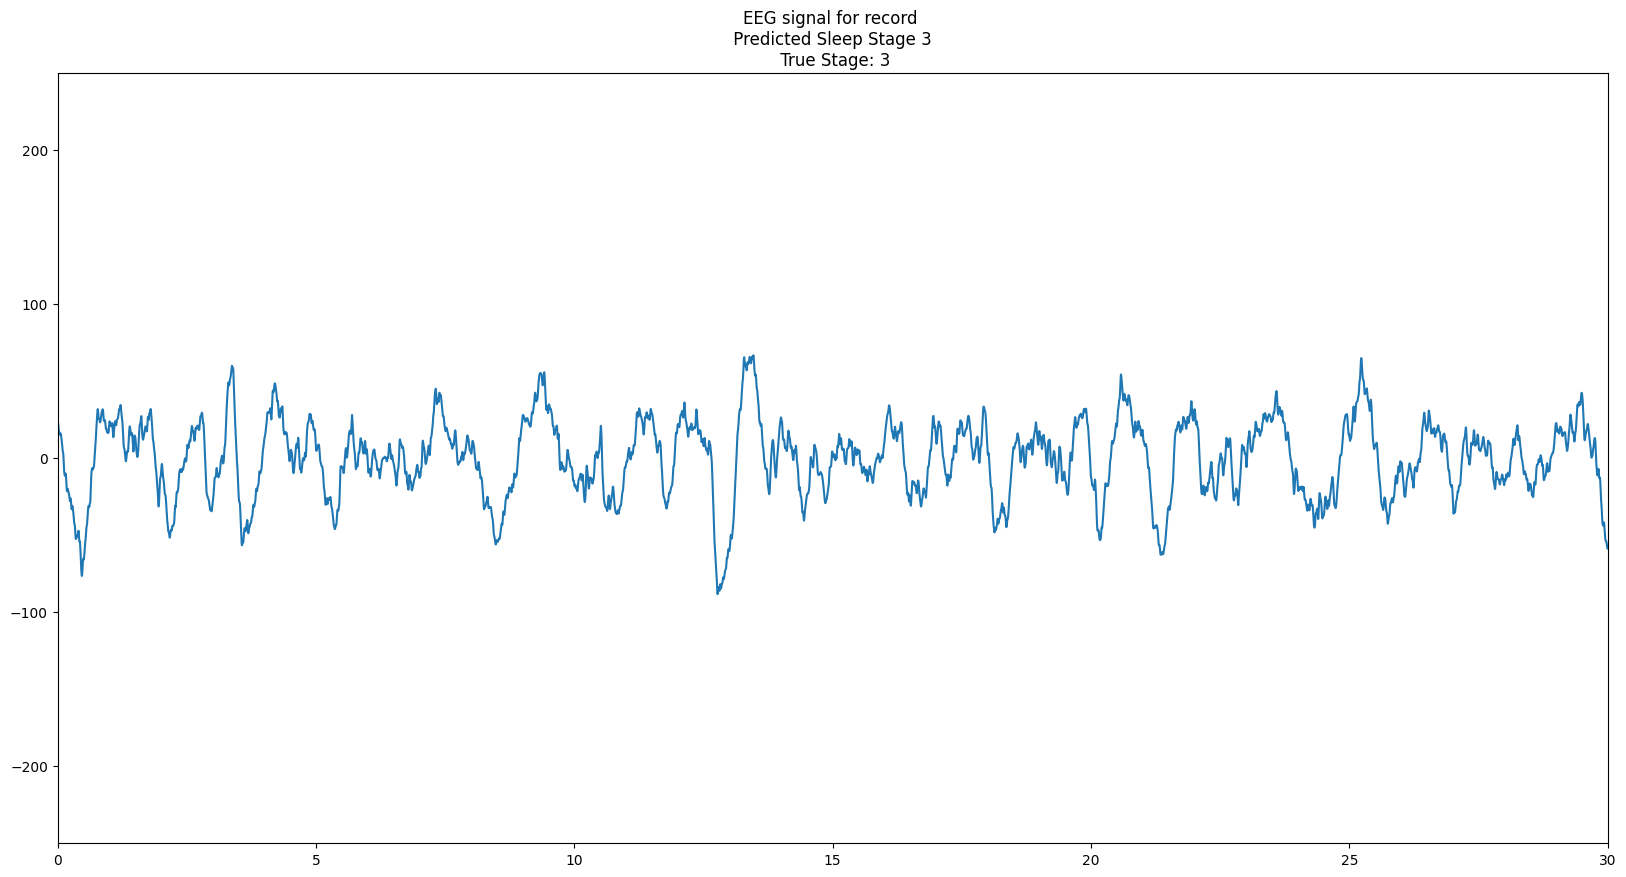

In [30]:
for epoch in correct_indexes_to_plot:
    print("########")
    print(epoch)
    
    plot_average_spectrum_for_epoch(epoch,raw_data,hypnogram, predicted_hypnogram)

    plot_spectrogram(epoch,raw_data,hypnogram, predicted_hypnogram)
    plot_epoch(epoch,raw_data,hypnogram, predicted_hypnogram)

########
618


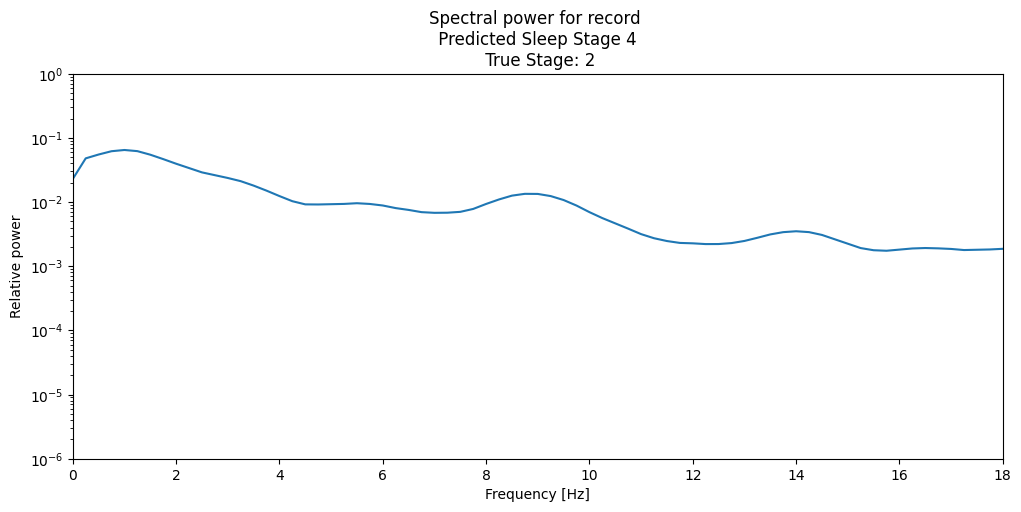

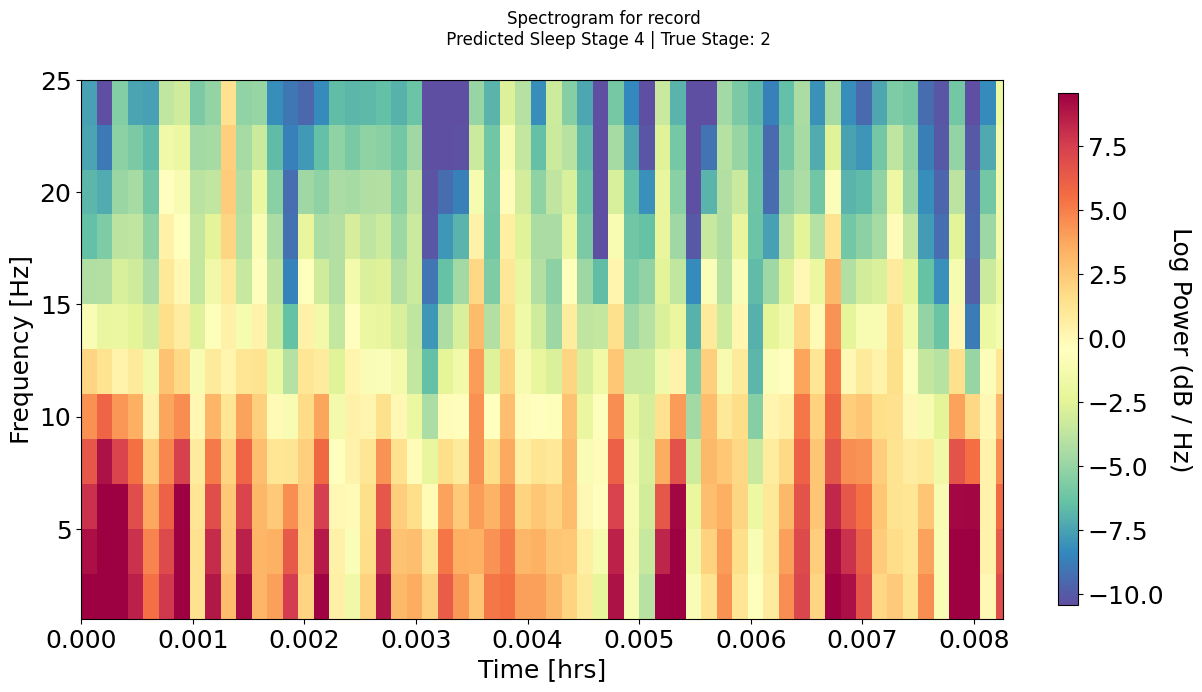

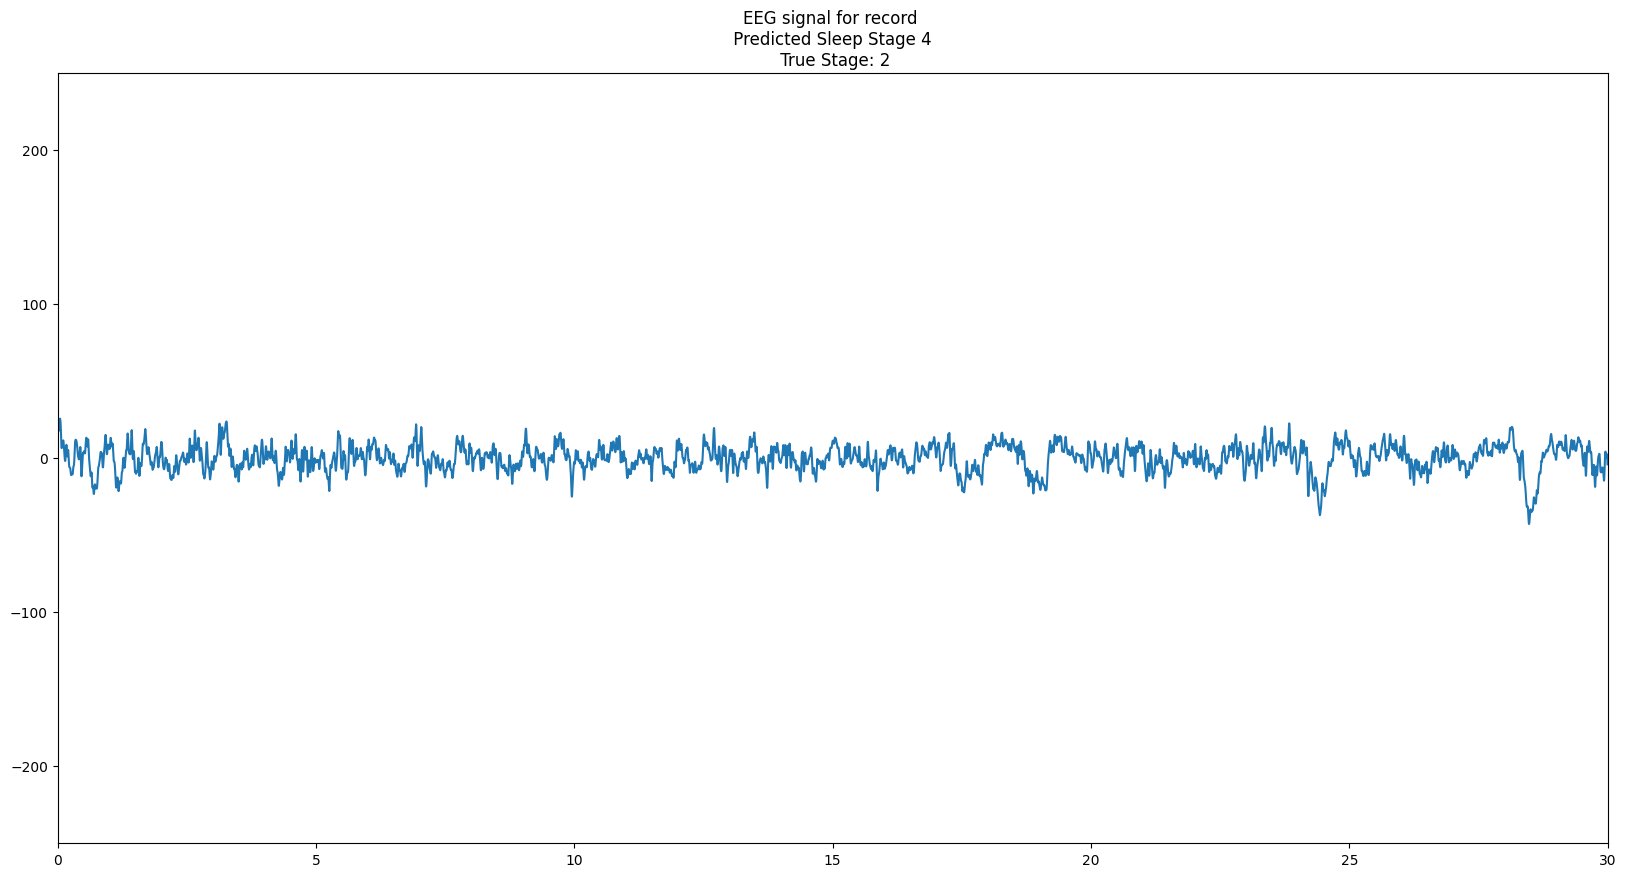

########
772


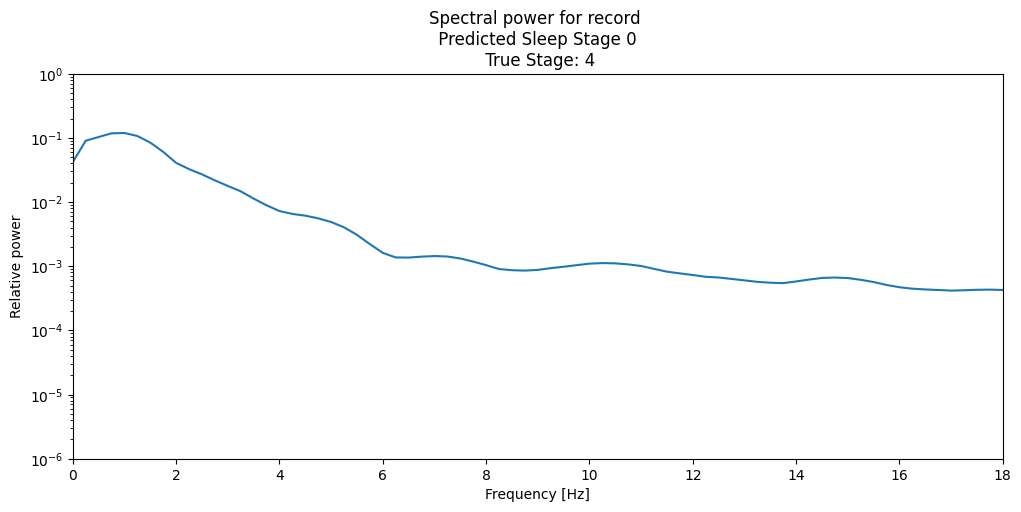

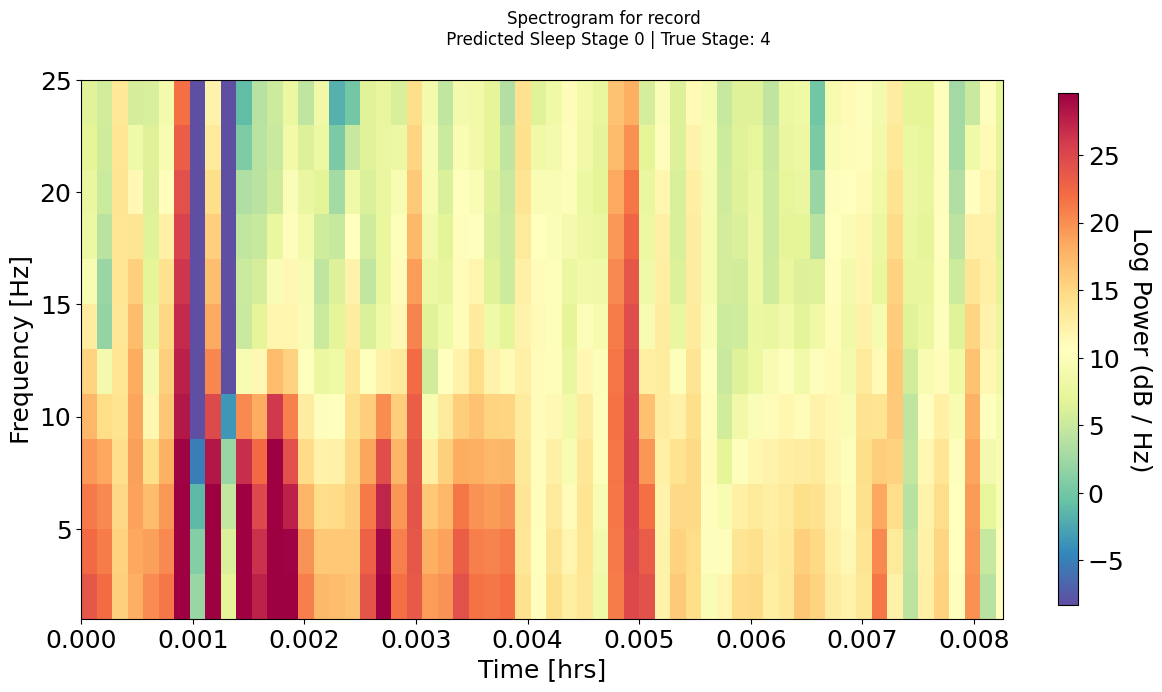

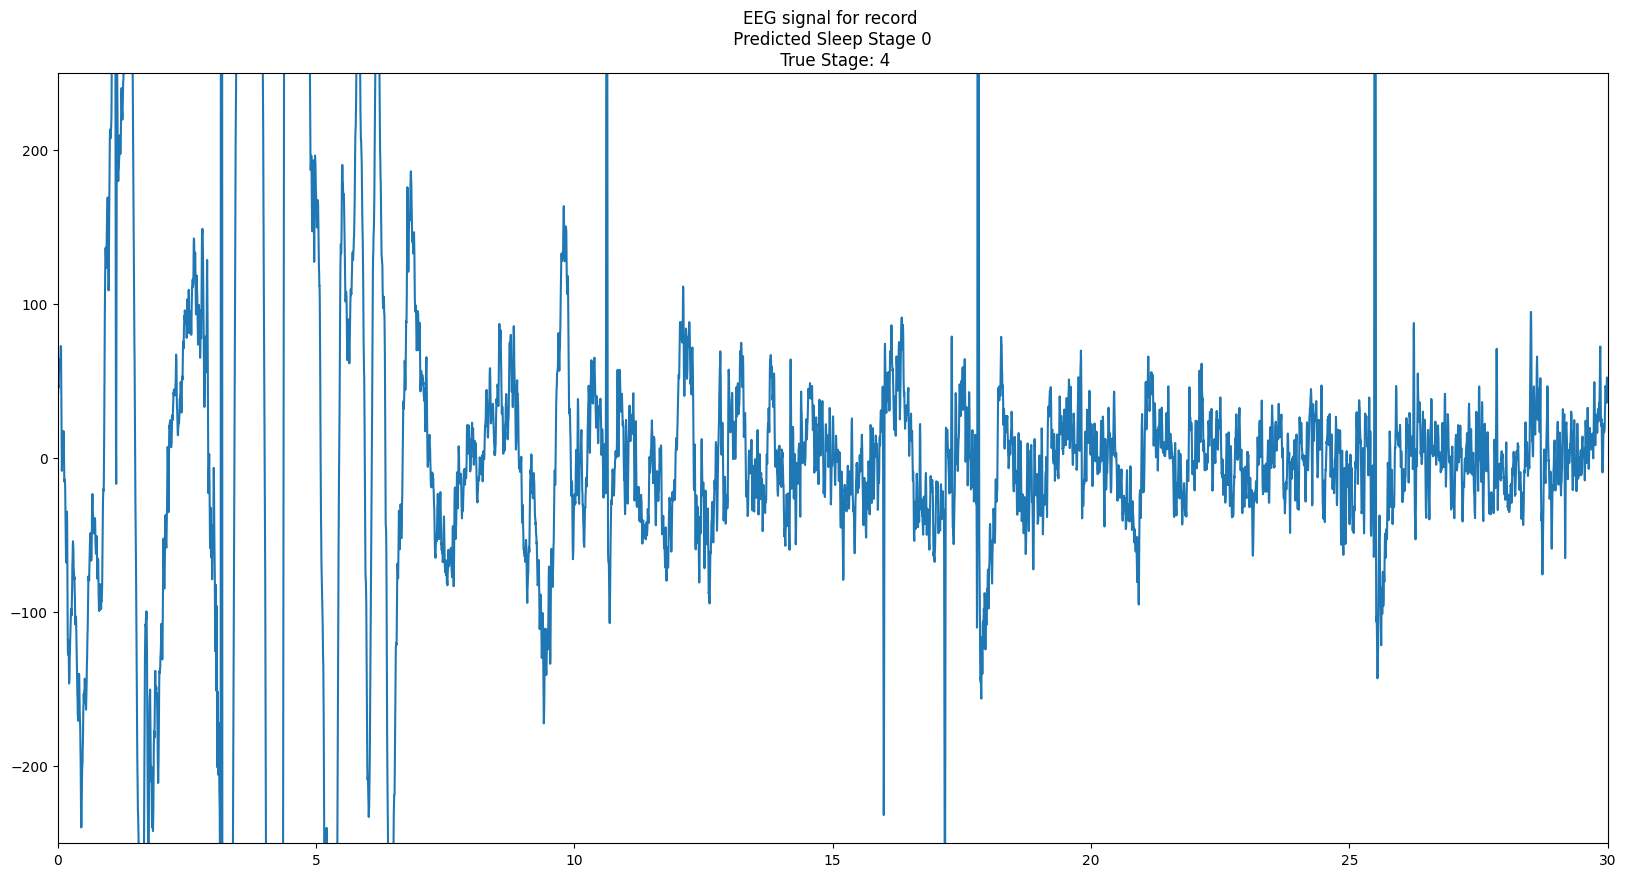

########
186


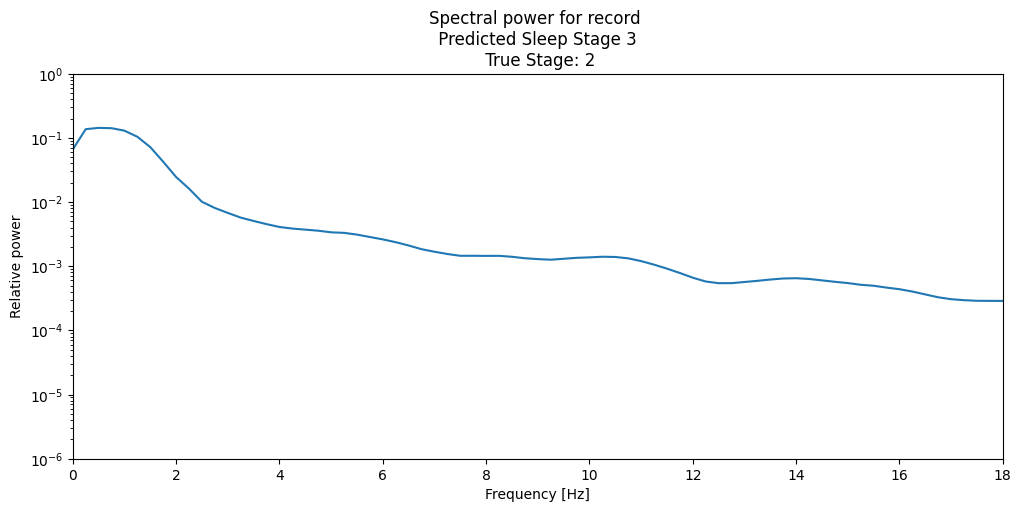

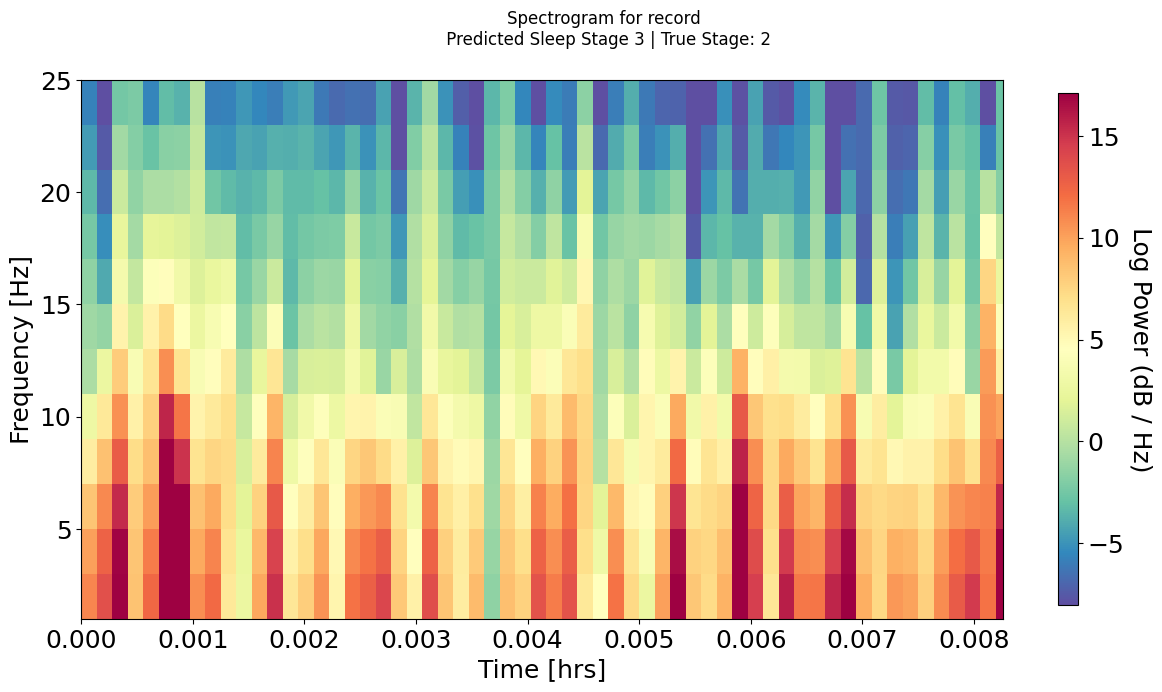

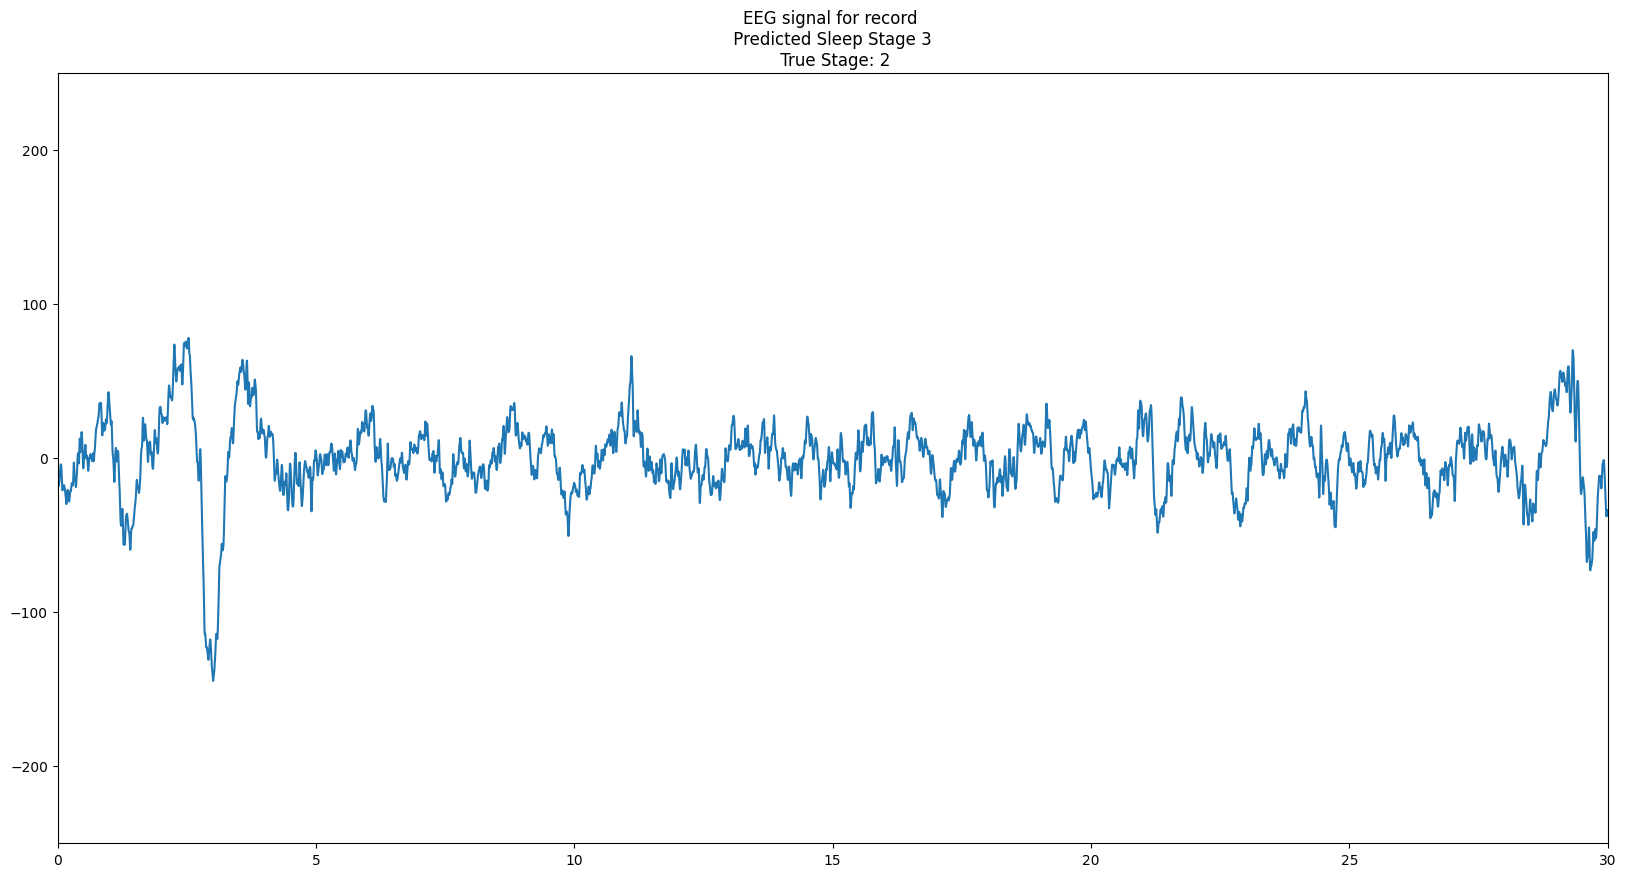

In [31]:
for epoch in wrong_indexes_to_plot:
    print("########")
    print(epoch)
    
    plot_average_spectrum_for_epoch(epoch,raw_data,hypnogram, predicted_hypnogram)

    plot_spectrogram(epoch,raw_data,hypnogram, predicted_hypnogram)
    plot_epoch(epoch,raw_data,hypnogram, predicted_hypnogram)

v = viz_model.view()     # render as SVG into internal object 
v.show() You've reached the end of this second tutorial.

Let's go to the last part about deep learning methods.
Open the **Tutorial_Sleep_Staging_C** tutorial